In [92]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection,linear_model, metrics, preprocessing
from xgboost import XGBRegressor

scaler = preprocessing.MinMaxScaler()

In [20]:
df = pd.read_csv("auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [186]:
X_raw = df.drop(["mpg"],axis=1)
y_raw = df[["mpg"]]
train, test = model_selection.train_test_split(df, test_size=0.2, random_state=42)
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

In [22]:
def summarize_table(df):
    print('DataFrame has {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    summary = pd.DataFrame(data=df.dtypes, columns=['dytpes'])
    summary.reset_index(inplace=True)
    summary['unique_values'] = df.nunique().values
    summary['missing_values'] = df.isnull().sum().values
    summary['missing_%'] = round(summary['missing_values'] / df.shape[0] * 100, 1)


    most_freq_1 = []
    most_freq_count_1 = []
    most_freq_2 = []
    most_freq_count_2 = []
    feat_entropy = []

    for col in df.columns:
        most_freq_1.append(df[col].value_counts().index[0])
        most_freq_count_1.append(df[col].value_counts().max())
        most_freq_2.append(df[col].value_counts().index[1])
        most_freq_count_2.append(df[col].value_counts().iloc[1:].max())
        feat_entropy.append(round(scipy.stats.entropy(df[col].value_counts(dropna=False, normalize=True), base=2), 2))

    summary['most_freq_value'] = most_freq_1
    summary['most_freq_value_count'] = most_freq_count_1
    summary['most_freq_value_count_%'] =  summary['most_freq_value_count']/df.shape[0]*100
    summary['2nd_most_freq_value'] = most_freq_2
    summary['2nd_most_freq_value_count'] = most_freq_count_2
    summary['2nd_most_freq_value_count_%'] = summary['2nd_most_freq_value_count']/df.shape[0]*100
    summary['feat_value_count_entropy'] = feat_entropy
    return summary

In [23]:
summarize_table(train)

DataFrame has 318 rows and 9 columns


,index,dytpes,unique_values,missing_values,missing_%,most_freq_value,most_freq_value_count,most_freq_value_count_%,2nd_most_freq_value,2nd_most_freq_value_count,2nd_most_freq_value_count_%,feat_value_count_entropy
0,mpg,float64,120,0,0.0,14,16,5.031447,13,16,5.031447,6.23
1,cylinders,int64,5,0,0.0,4,162,50.943396,8,79,24.842767,1.62
2,displacement,float64,78,0,0.0,97,18,5.660377,350,16,5.031447,5.67
3,horsepower,object,90,0,0.0,90,17,5.345912,150,16,5.031447,5.84
4,weight,int64,286,0,0.0,1985,4,1.257862,2155,3,0.943396,8.09
5,acceleration,float64,90,0,0.0,14.5,18,5.660377,15.5,14,4.402516,5.94
6,model year,int64,13,0,0.0,73,32,10.062893,78,31,9.748428,3.68
7,origin,int64,3,0,0.0,1,196,61.635220,3,66,20.754717,1.34
8,car name,object,246,0,0.0,ford pinto,5,1.572327,toyota corolla,5,1.572327,7.78


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 3 to 102
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           318 non-null    float64
 1   cylinders     318 non-null    int64  
 2   displacement  318 non-null    float64
 3   horsepower    318 non-null    object 
 4   weight        318 non-null    int64  
 5   acceleration  318 non-null    float64
 6   model year    318 non-null    int64  
 7   origin        318 non-null    int64  
 8   car name      318 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 24.8+ KB


In [25]:
def transform_problamtic_feature_to_numerical(df, feature):
    tmp = df.copy()
    tmp[feature] = pd.to_numeric(tmp[feature], errors = "coerce")
    return tmp

train = transform_problamtic_feature_to_numerical(train, "horsepower")
test = transform_problamtic_feature_to_numerical(test, "horsepower")

cylinder_median_horsepower_dict = train.groupby(by=["cylinders"])["horsepower"].median().to_dict()    
train.loc[train["horsepower"].isnull(),"horsepower"] = train["cylinders"].map(cylinder_median_horsepower_dict)
test.loc[test["horsepower"].isnull(),"horsepower"] = test["cylinders"].map(cylinder_median_horsepower_dict)
    

    

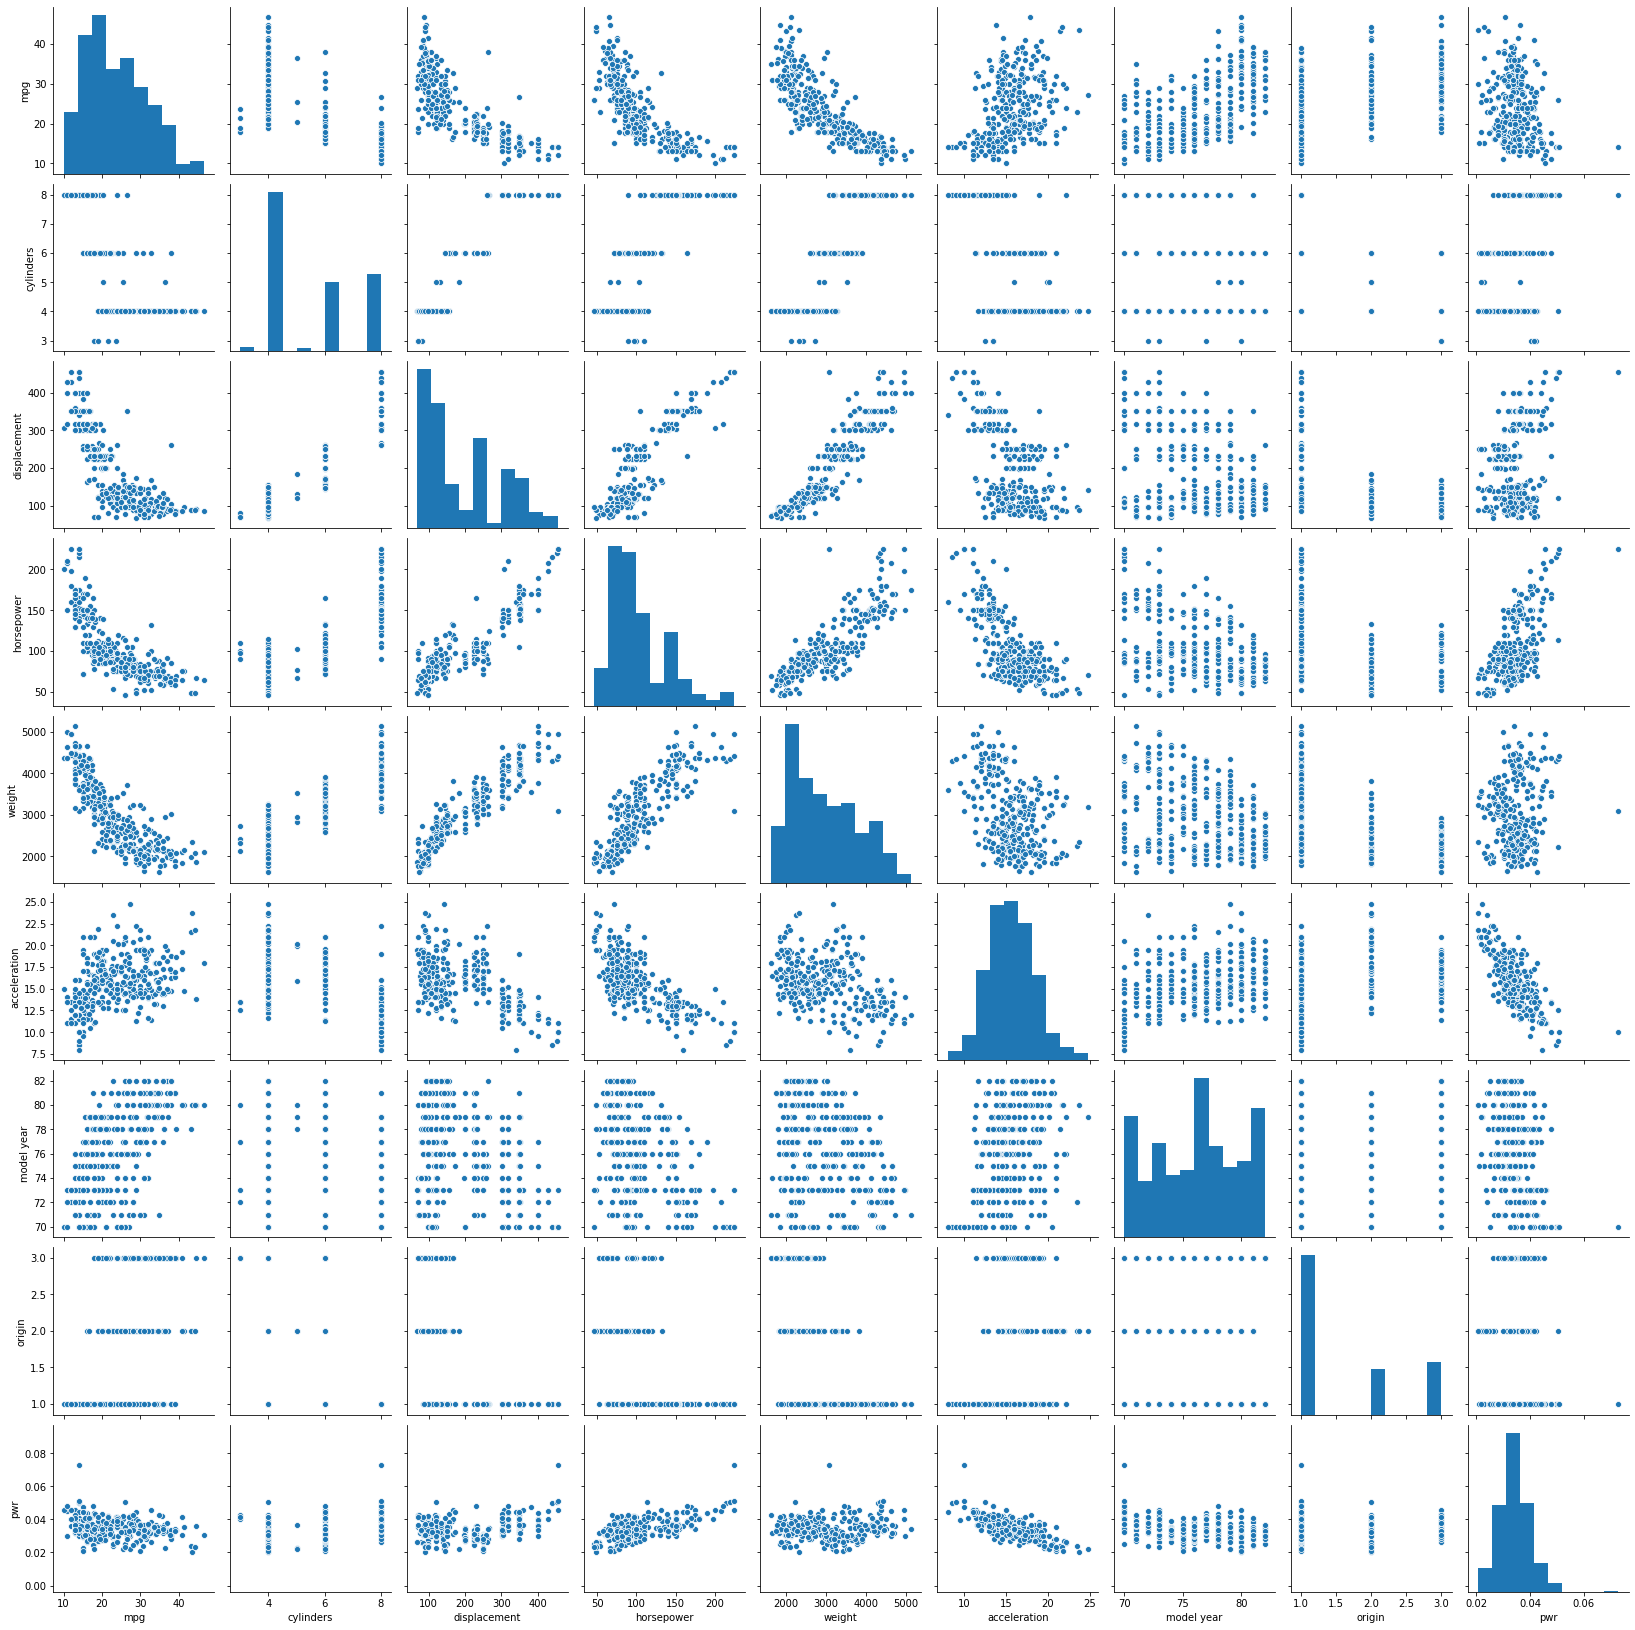

In [57]:
sns.pairplot(train)

In [27]:
train["car name"].str.split()

3                   [amc, rebel, sst]
18                    [datsun, pl510]
376           [mazda, glc, custom, l]
248              [honda, civic, cvcc]
177                     [audi, 100ls]
                    ...              
71                [mazda, rx2, coupe]
106      [oldsmobile, vista, cruiser]
270    [toyota, celica, gt, liftback]
348                  [toyota, tercel]
102       [volkswagen, super, beetle]
Name: car name, Length: 318, dtype: object

In [28]:
train["brand"] = train["car name"].str.split().str[0]
train["model"] = train["car name"].str.split().str[1]
# train["model"] = train["car name"].str.split().str[1:].str.join(",")

test["brand"] = test["car name"].str.split().str[0]
test["model"] = test["car name"].str.split().str[1]

In [29]:
train["pwr"] = train["horsepower"]/train["weight"]

In [30]:
train.groupby(by=["brand","origin"])["mpg"].median()

brand          origin
amc            1         18.00
audi           2         23.50
bmw            2         23.75
buick          1         17.35
cadillac       1         16.50
capri          1         25.00
chevroelt      1         16.00
chevrolet      1         17.75
chevy          1         13.00
chrysler       1         17.60
datsun         3         31.90
dodge          1         19.70
fiat           2         29.50
ford           1         18.00
hi             1          9.00
honda          3         33.70
maxda          3         18.00
mazda          3         31.60
mercedes       2         25.40
mercedes-benz  2         23.25
mercury        1         18.15
oldsmobile     1         23.90
opel           2         25.50
peugeot        2         25.00
plymouth       1         19.00
pontiac        1         19.00
renault        2         34.50
saab           2         22.80
subaru         3         31.15
toyota         3         29.00
triumph        2         35.00
vokswagen      2 

In [31]:
brand_dict = {
    "chevroelt":"chevrolet",
    "chevy":"chevrolet",
    "maxda":"mazda",
    "mercedes-benz":"mercedes",
    "vokswagen":"volkswagen",
    "vw":"volkswagen",
    "toyouta":"toyota"
}

In [32]:
train["brand"]= train["brand"].map(brand_dict).fillna(train['brand'])
test["brand"]= test["brand"].map(brand_dict).fillna(test['brand'])

In [33]:
train.groupby(by=["brand"])["mpg"].median()

brand
amc           18.00
audi          23.50
bmw           23.75
buick         17.35
cadillac      16.50
capri         25.00
chevrolet     17.50
chrysler      17.60
datsun        31.90
dodge         19.70
fiat          29.50
ford          18.00
hi             9.00
honda         33.70
mazda         31.45
mercedes      25.40
mercury       18.15
oldsmobile    23.90
opel          25.50
peugeot       25.00
plymouth      19.00
pontiac       19.00
renault       34.50
saab          22.80
subaru        31.15
toyota        29.00
triumph       35.00
volkswagen    30.15
volvo         21.00
Name: mpg, dtype: float64

In [34]:
country_dict = {
    "amc":"us",
    "audi":"germany",
    "bmw":"germany",
    "buick":"us",
    "cadillac":"us",
    "capri":"italy",
    "fiat":"italy",
    "chevrolet":"us",
    "chrysler":"us",
    "ford":"us",
    "datsun":"japan",
    "peugeot":"france",
    "dodge":"us",
    "renault":"france",
    "honda":"japan",
    "mazda":"japan",
    "mercedes":"germany",
    "oldsmobile":"us",
    "opel":"germany",
    "plymouth":"uk",
    "pontiac":"us",
    "saab":"sweden",
    "subaru":"japan",
    "toyota":"japan",
    "triumph":"uk",
    "volkswagen":"germany",
    "volvo":"sweden",
    "mercury":"egypt",
    "nissan":"japan"
}
train["country"]= train["brand"].map(country_dict)
test["country"]= test["brand"].map(country_dict)

In [42]:
train = train.dropna(axis=0)
train

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,brand,model,pwr,country
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,amc,rebel,0.043694,us
18,27.0,4,97.0,88.0,2130,14.5,70,3,datsun pl510,datsun,pl510,0.041315,japan
376,37.0,4,91.0,68.0,2025,18.2,82,3,mazda glc custom l,mazda,glc,0.033580,japan
248,36.1,4,91.0,60.0,1800,16.4,78,3,honda civic cvcc,honda,civic,0.033333,japan
177,23.0,4,115.0,95.0,2694,15.0,75,2,audi 100ls,audi,100ls,0.035264,germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,19.0,3,70.0,97.0,2330,13.5,72,3,mazda rx2 coupe,mazda,rx2,0.041631,japan
106,12.0,8,350.0,180.0,4499,12.5,73,1,oldsmobile vista cruiser,oldsmobile,vista,0.040009,us
270,21.1,4,134.0,95.0,2515,14.8,78,3,toyota celica gt liftback,toyota,celica,0.037773,japan
348,37.7,4,89.0,62.0,2050,17.3,81,3,toyota tercel,toyota,tercel,0.030244,japan


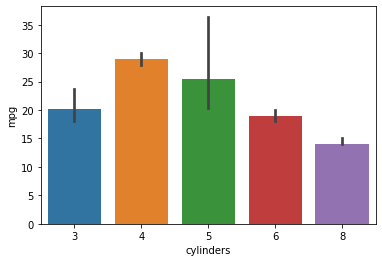

In [63]:
sns.barplot(data = train, y = "mpg", x = "cylinders", estimator = np.median)

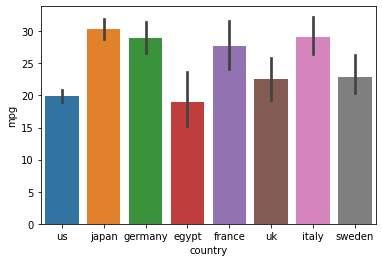

In [37]:
sns.barplot(data = train, y = "mpg", x = "country")

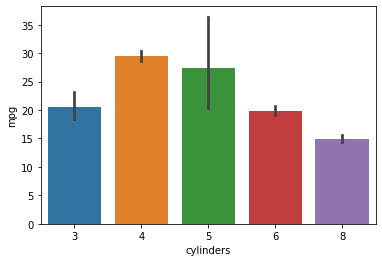

In [51]:
sns.barplot(data = train, y = "mpg", x = "cylinders")

In [244]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

def transform_problamtic_feature_to_numerical(df, feature):
    tmp = df.copy()
    tmp[feature] = pd.to_numeric(tmp[feature], errors = "coerce")
    return tmp

X_train = transform_problamtic_feature_to_numerical(X_train, "horsepower")
X_test = transform_problamtic_feature_to_numerical(X_test, "horsepower")

cylinder_median_horsepower_dict = X_train.groupby(by=["cylinders"])["horsepower"].median().to_dict() 

def preprocessor(df, istrain=True):
    tmp = df.copy()
    
    tmp.loc[tmp["horsepower"].isnull(),"horsepower"] = tmp["cylinders"].map(cylinder_median_horsepower_dict)
    tmp["brand"] = tmp["car name"].str.split().str[0]
    tmp["model"] = tmp["car name"].str.split().str[1]
    tmp["pwr"] = tmp["horsepower"]/tmp["weight"] 
    
    brand_dict = {
    "chevroelt":"chevrolet",
    "chevy":"chevrolet",
    "maxda":"mazda",
    "mercedes-benz":"mercedes",
    "vokswagen":"volkswagen",
    "vw":"volkswagen",
    "toyouta":"toyota"
    }
    tmp["brand"]= tmp["brand"].map(brand_dict).fillna(tmp['brand'])
    country_dict = {
    "amc":"us",
    "audi":"germany",
    "bmw":"germany",
    "buick":"us",
    "cadillac":"us",
    "capri":"us",
    "fiat":"italy",
    "chevrolet":"us",
    "chrysler":"us",
    "ford":"us",
    "datsun":"japan",
    "peugeot":"france",
    "dodge":"us",
    "renault":"france",
    "honda":"japan",
    "mazda":"japan",
    "mercedes":"germany",
    "oldsmobile":"us",
    "opel":"germany",
    "plymouth":"uk",
    "pontiac":"us",
    "saab":"sweden",
    "subaru":"japan",
    "toyota":"japan",
    "triumph":"uk",
    "volkswagen":"germany",
    "volvo":"sweden",
    "mercury":"egypt",
    "nissan":"japan"
    }
    tmp["country"]= tmp["brand"].map(country_dict)
    
    cylinder_dict = {
        3:6,
        5:6
    }
    tmp["cylinders"]= tmp["cylinders"].map(cylinder_dict).fillna(tmp["cylinders"])
    tmp["disp_to_weight_rat"] = tmp["displacement"]/tmp["weight"]
    
    
    tmp["cylinders"] = tmp["cylinders"].astype(str)
    tmp["origin"] = tmp["origin"].astype(str)
    
    tmp["annum"] = "70's"
    tmp.loc[tmp["model year"]>=80,"annum"] = "80's"
    
    del tmp["car name"]
    del tmp["country"]
    del tmp["model"]
    del tmp["brand"]

    
    num_features = tmp.select_dtypes(include=np.number).columns.tolist()
    str_features = [feat for feat in tmp.columns.tolist() if feat not in num_features]
    
    if "mpg" in num_features:
        num_features.remove("mpg")
    
    if istrain:
        tmp[num_features] = scaler.fit_transform(tmp[num_features])
    else: 
        tmp[num_features] = scaler.transform(tmp[num_features])
    
    
    dummy_df = pd.get_dummies(tmp[str_features], drop_first=True)
    tmp = tmp.drop(str_features,axis=1)
    tmp = pd.concat([tmp, dummy_df], axis = 1)
    return tmp


X_train = preprocessor(X_train)
X_test = preprocessor(X_test,False)

In [245]:
X_train.head()

,displacement,horsepower,weight,acceleration,model year,pwr,disp_to_weight_rat,cylinders_6.0,cylinders_8.0,origin_2,origin_3,annum_80's
3,0.609819,0.581006,0.516019,0.238095,0.000000,0.441937,0.503117,0,1,0,0,0
18,0.074935,0.234637,0.146583,0.386905,0.000000,0.396496,0.140188,0,0,0,1,0
376,0.059432,0.122905,0.116813,0.607143,1.000000,0.248762,0.135111,0,0,0,1,1
248,0.059432,0.078212,0.053020,0.500000,0.666667,0.244046,0.182509,0,0,0,1,0
177,0.121447,0.273743,0.306493,0.416667,0.416667,0.280915,0.116119,0,0,1,0,0


In [246]:
X_test.head()

,displacement,horsepower,weight,acceleration,model year,pwr,disp_to_weight_rat,cylinders_6.0,cylinders_8.0,origin_2,origin_3,annum_80's
198,0.059432,0.039106,0.051602,0.559524,0.500000,0.171331,0.183697,0,0,0,1,0
396,0.134367,0.184358,0.286929,0.630952,1.000000,0.182195,0.141659,0,0,0,0,1
33,0.423773,0.301676,0.289481,0.297619,0.083333,0.332517,0.499124,1,0,0,0,0
208,0.645995,0.581006,0.659768,0.309524,0.500000,0.334542,0.436951,0,1,0,0,0
93,0.645995,0.581006,0.743975,0.386905,0.250000,0.283568,0.389214,0,1,0,0,0


In [247]:
X_train.shape

(318, 12)

In [248]:
X_test.shape

(80, 12)

In [249]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

5.932326222617995

In [250]:
xgb_model = XGBRegressor(seed=42)
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

[15:03:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


5.390266125161695

In [251]:
# grid search
lr = linear_model.LinearRegression()
grid_model = model_selection.GridSearchCV(lr, param_grid={},cv = 5,scoring="neg_mean_squared_error")
grid_model.fit(X_train,y_train)
grid_model.cv_results_

{'mean_fit_time': array([0.00296445]),
 'std_fit_time': array([0.00048872]),
 'mean_score_time': array([0.00135541]),
 'std_score_time': array([0.00034523]),
 'params': [{}],
 'split0_test_score': array([-7.93189711]),
 'split1_test_score': array([-8.04608009]),
 'split2_test_score': array([-11.7916449]),
 'split3_test_score': array([-10.22770845]),
 'split4_test_score': array([-8.75323347]),
 'mean_test_score': array([-9.3501128]),
 'std_test_score': array([1.46964997]),
 'rank_test_score': array([1], dtype=int32)}

In [252]:
pred = grid_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

5.932326222617995

In [211]:
# grid search
xgb_model = XGBRegressor(seed=42)
grid_model = model_selection.GridSearchCV(xgb_model, param_grid={"objective":["reg:squarederror"],"max_depth":[6],"gamma":[1,2,3]},cv = 5,scoring="neg_mean_squared_error")
grid_model.fit(X_train,y_train)
grid_model.cv_results_

{'mean_fit_time': array([0.05567207, 0.04986625, 0.04513083]),
 'std_fit_time': array([0.00640182, 0.00117564, 0.00127661]),
 'mean_score_time': array([0.00240092, 0.00161142, 0.00142155]),
 'std_score_time': array([1.08341295e-03, 9.42995845e-05, 1.16225925e-04]),
 'param_gamma': masked_array(data=[1, 2, 3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6, 6, 6],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_objective': masked_array(data=['reg:squarederror', 'reg:squarederror',
                    'reg:squarederror'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 1, 'max_depth': 6, 'objective': 'reg:squarederror'},
  {'gamma': 2, 'max_depth': 6, 'objective': 'reg:squarederror'},
  {'gamma': 3, 'max_depth': 6, 'objective': 'reg:squarederror'}],
 'split0_test_score': array([-8.

In [214]:
pred = grid_model.predict(X_test)
metrics.mean_squared_error(y_test,pred)

4.731782529439647

In [215]:
metrics.mean_absolute_error(y_test,pred)

1.6739378046989444

In [195]:
train, test = model_selection.train_test_split(df, test_size=0.2, random_state=42)

train = transform_problamtic_feature_to_numerical(train, "horsepower")
test = transform_problamtic_feature_to_numerical(test, "horsepower")

cylinder_median_horsepower_dict = train.groupby(by=["cylinders"])["horsepower"].median().to_dict()    
    
train = preprocessor(train)
test = preprocessor(test,False)

In [196]:
train.head()

,mpg,displacement,horsepower,weight,acceleration,model year,pwr,disp_to_weight_rat,cylinders_6.0,cylinders_8.0,origin_2,origin_3,annum_80's
3,16.0,0.609819,0.581006,0.516019,0.238095,0.000000,0.441937,0.503117,0,1,0,0,0
18,27.0,0.074935,0.234637,0.146583,0.386905,0.000000,0.396496,0.140188,0,0,0,1,0
376,37.0,0.059432,0.122905,0.116813,0.607143,1.000000,0.248762,0.135111,0,0,0,1,1
248,36.1,0.059432,0.078212,0.053020,0.500000,0.666667,0.244046,0.182509,0,0,0,1,0
177,23.0,0.121447,0.273743,0.306493,0.416667,0.416667,0.280915,0.116119,0,0,1,0,0


In [197]:
test.head()

,mpg,displacement,horsepower,weight,acceleration,model year,pwr,disp_to_weight_rat,cylinders_6.0,cylinders_8.0,origin_2,origin_3,annum_80's
198,33.0,0.059432,0.039106,0.051602,0.559524,0.500000,0.171331,0.183697,0,0,0,1,0
396,28.0,0.134367,0.184358,0.286929,0.630952,1.000000,0.182195,0.141659,0,0,0,0,1
33,19.0,0.423773,0.301676,0.289481,0.297619,0.083333,0.332517,0.499124,1,0,0,0,0
208,13.0,0.645995,0.581006,0.659768,0.309524,0.500000,0.334542,0.436951,0,1,0,0,0
93,14.0,0.645995,0.581006,0.743975,0.386905,0.250000,0.283568,0.389214,0,1,0,0,0


In [206]:
test["pred_mpg"] = pred
test["pred_mpg"] = test["pred_mpg"].apply(lambda x: round(x,1))

In [222]:
test["diff_mpg"] = np.abs(test["mpg"] - test["pred_mpg"])
test["diff_mpg_flag"] = 0
test.loc[test["diff_mpg"]>2,"diff_mpg_flag"] = 1
test.head()

,mpg,displacement,horsepower,weight,acceleration,model year,pwr,disp_to_weight_rat,cylinders_6.0,cylinders_8.0,origin_2,origin_3,annum_80's,pred_mpg,diff_mpg,diff_mpg_flag
198,33.0,0.059432,0.039106,0.051602,0.559524,0.500000,0.171331,0.183697,0,0,0,1,0,32.1,0.9,0
396,28.0,0.134367,0.184358,0.286929,0.630952,1.000000,0.182195,0.141659,0,0,0,0,1,30.8,2.8,1
33,19.0,0.423773,0.301676,0.289481,0.297619,0.083333,0.332517,0.499124,1,0,0,0,0,21.0,2.0,0
208,13.0,0.645995,0.581006,0.659768,0.309524,0.500000,0.334542,0.436951,0,1,0,0,0,15.7,2.7,1
93,14.0,0.645995,0.581006,0.743975,0.386905,0.250000,0.283568,0.389214,0,1,0,0,0,13.8,0.2,0


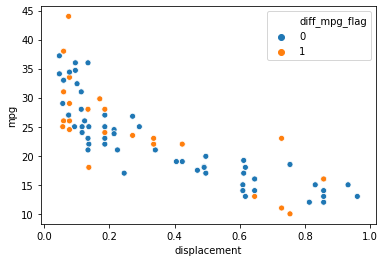

In [223]:
sns.scatterplot(data = test, x = "displacement", y = "mpg", hue = "diff_mpg_flag")

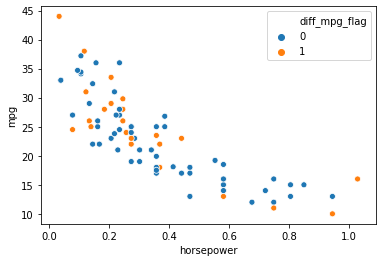

In [224]:
sns.scatterplot(data = test, x = "horsepower", y = "mpg", hue = "diff_mpg_flag")

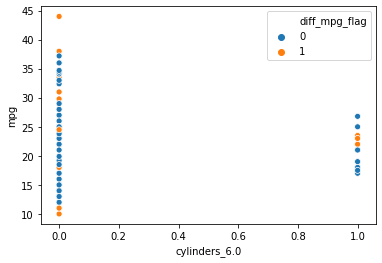

In [228]:
sns.scatterplot(data = test, x = "cylinders_6.0", y = "mpg", hue = "diff_mpg_flag")

In [253]:
pred = lr_model.predict(X_train)
X_train["pred_mpg"] = pred
X_train["pred_mpg"] = X_train["pred_mpg"].apply(lambda x: round(x,1))

pred = lr_model.predict(X_test)
X_test["pred_mpg"] = pred
X_test["pred_mpg"] = X_test["pred_mpg"].apply(lambda x: round(x,1))

In [254]:
xgb_model1 = XGBRegressor(seed=42)
grid_model1 = model_selection.GridSearchCV(xgb_model1, param_grid={"objective":["reg:squarederror"],"max_depth":[6],"gamma":[1,1.2,1.8,2]},cv = 5,scoring="neg_mean_squared_error")
grid_model1.fit(X_train,y_train)
grid_model1.cv_results_

{'mean_fit_time': array([0.05416493, 0.05127616, 0.05314593, 0.05612206]),
 'std_fit_time': array([0.00777012, 0.00138901, 0.00349205, 0.00109665]),
 'mean_score_time': array([0.00165367, 0.00213985, 0.00163708, 0.00189295]),
 'std_score_time': array([0.00018517, 0.00066422, 0.00018546, 0.00021929]),
 'param_gamma': masked_array(data=[1, 1.2, 1.8, 2],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6, 6, 6, 6],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_objective': masked_array(data=['reg:squarederror', 'reg:squarederror',
                    'reg:squarederror', 'reg:squarederror'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 1, 'max_depth': 6, 'objective': 'reg:squarederror'},
  {'gamma': 1.2, 'max_depth': 6, 'objective': 'reg:squarederror'},
  {'gamma

In [255]:
pred = grid_model1.predict(X_test)
metrics.mean_squared_error(y_test,pred)

4.719710595672909

In [256]:
metrics.mean_absolute_error(y_test,pred)

1.6620146203041077

In [257]:
grid_model1.best_params_

{'gamma': 2, 'max_depth': 6, 'objective': 'reg:squarederror'}